In [1]:
%matplotlib inline

In [2]:
from datasets import load_dataset

monad_gpt = load_dataset("Pclanglais/MonadGPT")
monad_gpt = monad_gpt.map(
    lambda x: {
        "final_answer": x["conversation"]
        .split("<|im_start|>")[-1]
        .removeprefix(" assistant")
        .removesuffix("<|im_end|>\n")
    }
)["train"]

In [3]:
import pandas as pd
from pathlib import Path

datadir = Path("data")
df_selected = pd.read_csv("selected_works.csv")
ds = load_dataset(
    "json", data_files=str(datadir.joinpath("interim", "paragraphs_simple_split.jsonl"))
)["train"]

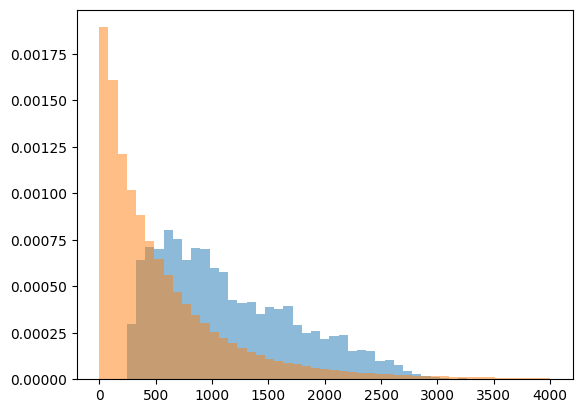

In [4]:
import numpy as np
import matplotlib.pyplot as plt


answers = monad_gpt["final_answer"]
ds_lengths = [len(p) for p in ds["paragraph"]]

_, ax = plt.subplots()
bins = np.linspace(0, 4000, 50)
ax.hist(([len(a) for a in answers]), bins=bins, alpha=0.5, density=True)
ax.hist(ds_lengths, bins=bins, alpha=0.5, density=True);

Some acrobatics to try to have our dataset resemble MonadGPT's distribution of answer lengths

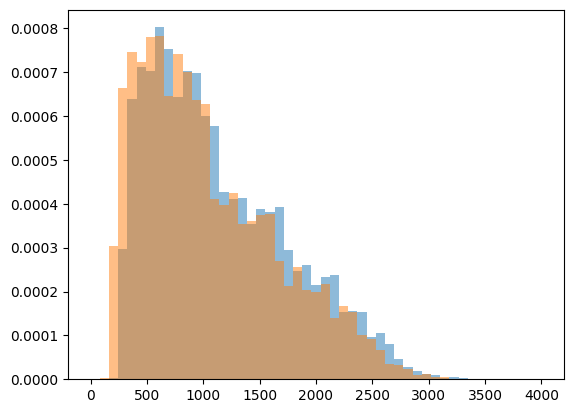

In [5]:
import numpy as np

ds_lengths_digitized = np.digitize(ds_lengths, bins)
ds_lengths_probs = np.bincount(ds_lengths_digitized) / len(ds_lengths_digitized)

monad_lengths_digitized = np.digitize([len(a) for a in answers], bins)
monad_lengths_probs = np.bincount(monad_lengths_digitized) / len(monad_lengths_digitized)

ds_hist, bin_edges_ds = np.histogram(ds_lengths, bins=bins, density=True)
monad_hist, bin_edges_monad = np.histogram([len(a) for a in answers], bins=bins, density=True)

ratios = monad_hist / ds_hist
ratios[ds_hist == 0] = 0.


sampling_probs = ratios[np.digitize(ds_lengths, bins[:-2])]
sampling_probs /= sampling_probs.sum()

_, ax = plt.subplots()
bins = np.linspace(0, 4000, 50)
ax.hist(([len(a) for a in answers]), bins=bins, alpha=0.5, density=True)

selected_lengths = np.random.choice(ds_lengths, size=len(answers), p=sampling_probs, replace=False)
ax.hist(selected_lengths, bins=bins, alpha=0.5, density=True);

In [6]:
sampled_paragraphs = np.random.choice(np.arange(len(ds)), size=len(answers), p=sampling_probs, replace=False)

In [7]:
ds.select(sampled_paragraphs)

Dataset({
    features: ['prefix', 'paragraph_index', 'paragraph'],
    num_rows: 10797
})

In [8]:
for rec in ds.select(sampled_paragraphs):
    print(rec)
    break

{'prefix': 'N14342', 'paragraph_index': 178, 'paragraph': 'This harangue did but increase their consternation. As soon as they began to\nhear the terrible roaring of our batteries, we that were on the heights saw\nthem flying precipitately from their redoubts, while their batteries in an\ninstant were entirely silenced. They had been quiet spectators of our labors,\nand we now became so in our turn with respect to them. At this time I watched\nan opportunity to traverse our lines, which consisted of a large ditch, broad\nenough for carriages to travel in, about four feet in depth, and covered by a\nrampart of gabions, or cylindrical baskets, fixed upon the ground, by means of\nprojecting stakes, filled and covered over with loose dirt, and forming a\nheight of about seven feet on the side toward the enemy. The batteries were\nplaced upon platforms, on the inside of the ditch, raised and strengthened with\npalisadoes. The quarter next the enemy was covered by a large parapet, in which\n

In [9]:
import json

with open(datadir / "interim/answers.jsonl", "w", encoding="utf-8") as f:
    for rec in ds.select(sampled_paragraphs):
        f.write(json.dumps(rec) + "\n")